# Cloud Workshop Azure Databricks
## 12. Azure Databricks et MLFlow - Scikit Learn
<img src="https://raw.githubusercontent.com/retkowsky/images/master/AzureDatabricksLogo.jpg"><br>
V1.3 12/06/2019

## MLflow Quick Start: Training and Logging
This is a Quick Start notebook based on [MLflow's tutorial](https://mlflow.org/docs/latest/tutorial.html).  In this tutorial, we’ll:
* Install the MLflow library on a Databricks cluster
* Train a diabetes progression model and log metrics, parameters, models, and a .png plot from the training to the MLflow tracking server
* View the training results in the MLflow experiment UI

This notebook uses the `diabetes` dataset in scikit-learn and predicts the progression metric (a quantitative measure of disease progression after one year after) based on BMI, blood pressure, etc. It uses the scikit-learn ElasticNet linear regression model, where we vary the `alpha` and `l1_ratio` parameters for tuning. For more information on ElasticNet, refer to:
  * [Elastic net regularization](https://en.wikipedia.org/wiki/Elastic_net_regularization)
  * [Regularization and Variable Selection via the Elastic Net](https://web.stanford.edu/~hastie/TALKS/enet_talk.pdf)

## 1. Setup

In [4]:
import mlflow

In [5]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import lasso_path, enet_path
from sklearn import datasets

import mlflow
import mlflow.sklearn

## 2. Données

In [7]:
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

Y = np.array([y]).transpose()
d = np.concatenate((X, Y), axis=1)
cols = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'progression']
data = pd.DataFrame(d, columns=cols)

In [8]:
display(data)

age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,progression
0.0380759064334241,0.0506801187398187,0.0616962065186885,0.0218723549949558,-0.0442234984244464,-0.0348207628376986,-0.0434008456520269,-0.00259226199818282,0.0199084208763183,-0.0176461251598052,151.0
-0.00188201652779104,-0.044641636506989,-0.0514740612388061,-0.0263278347173518,-0.00844872411121698,-0.019163339748222,0.0744115640787594,-0.0394933828740919,-0.0683297436244215,-0.09220404962683,75.0
0.0852989062966783,0.0506801187398187,0.0444512133365941,-0.00567061055493425,-0.0455994512826475,-0.0341944659141195,-0.0323559322397657,-0.00259226199818282,0.00286377051894013,-0.0259303389894746,141.0
-0.0890629393522603,-0.044641636506989,-0.0115950145052127,-0.0366564467985606,0.0121905687618,0.0249905933641021,-0.0360375700438527,0.0343088588777263,0.0226920225667445,-0.0093619113301358,206.0
0.00538306037424807,-0.044641636506989,-0.0363846922044735,0.0218723549949558,0.00393485161259318,0.0155961395104161,0.0081420836051921,-0.00259226199818282,-0.0319914449413559,-0.0466408735636482,135.0
-0.0926954778032799,-0.044641636506989,-0.0406959404999971,-0.0194420933298793,-0.0689906498720667,-0.0792878444118122,0.0412768238419757,-0.076394503750001,-0.0411803851880079,-0.0963461565416647,97.0
-0.0454724779400257,0.0506801187398187,-0.0471628129432825,-0.015999222636143,-0.040095639849843,-0.0248000120604336,7.78807997017968E-4,-0.0394933828740919,-0.0629129499162512,-0.0383566597339788,138.0
0.063503675590561,0.0506801187398187,-0.00189470584028465,0.0666296740135272,0.0906198816792644,0.108914381123697,0.0228686348215404,0.0177033544835672,-0.0358167281015492,0.00306440941436832,63.0
0.0417084448844436,0.0506801187398187,0.0616962065186885,-0.0400993174922969,-0.0139525355440215,0.00620168565673016,-0.0286742944356786,-0.00259226199818282,-0.0149564750249113,0.0113486232440377,110.0
-0.0709002470971626,-0.044641636506989,0.0390621529671896,-0.0332135761048244,-0.0125765826858204,-0.034507614375909,-0.0249926566315915,-0.00259226199818282,0.0677363261102861,-0.0135040182449705,310.0


## 3. Fonctions

#### Plot the ElasticNet Descent Path
As an example of recording arbitrary output files in MLflow, we'll plot the [ElasticNet Descent Path](http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html) for the ElasticNet model by *alpha* for the specified *l1_ratio*.

The `plot_enet_descent_path` function below:
* Returns an image that can be displayed in our Databricks notebook via `display`
* As well as saves the figure `ElasticNet-paths.png` to the Databricks cluster's driver node
* This file is then uploaded to MLflow using the `log_artifact` within `train_diabetes`

In [11]:
def plot_enet_descent_path(X, y, l1_ratio):
  
    # Compute paths
    eps = 15e-3  # the smaller it is the longer is the path

    # Reference the global image variable
    global image
    
    print("Computing regularization path using the elastic net.")
    alphas_enet, coefs_enet, _ = enet_path(X, y, eps=eps, l1_ratio=l1_ratio, fit_intercept=False)

    # Display results
    fig = plt.figure(1)
    ax = plt.gca()

    colors = cycle(['b', 'r', 'g', 'c', 'k'])
    neg_log_alphas_enet = -np.log10(alphas_enet)
    for coef_e, c in zip(coefs_enet, colors):
        l1 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)

    plt.xlabel('-Log(alpha)')
    plt.ylabel('coefficients')
    title = 'ElasticNet Path by alpha for l1_ratio = ' + str(l1_ratio)
    plt.title(title)
    plt.axis('tight')

    # Display images
    image = fig
    
    # Save figure
    fig.savefig("ElasticNet-paths.png")

    # Close plot
    plt.close(fig)

    # Return images
    return image    

#### Train the Diabetes Model
The next function trains Elastic-Net linear regression based on the input parameters of `alpha (in_alpha)` and `l1_ratio (in_l1_ratio)`.

In addition, this function uses MLflow Tracking to record its
* parameters
* metrics
* model
* arbitrary files, namely the above noted Lasso Descent Path plot.

**Tip:** We use `with mlflow.start_run:` in the Python code to create a new MLflow run. This is the recommended way to use MLflow in notebook cells. Whether your code completes or exits with an error, the `with` context will make sure that we close the MLflow run, so you don't have to call `mlflow.end_run` later in the code.

In [13]:
# train_diabetes
#   Uses the sklearn Diabetes dataset to predict diabetes progression using ElasticNet
#       The predicted "progression" column is a quantitative measure of disease progression one year after baseline
#       http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html

def train_diabetes(data, in_alpha, in_l1_ratio):
  # Evaluate metrics
  def eval_metrics(actual, pred):
      rmse = np.sqrt(mean_squared_error(actual, pred))
      mae = mean_absolute_error(actual, pred)
      r2 = r2_score(actual, pred)
      return rmse, mae, r2

  warnings.filterwarnings("ignore")
  np.random.seed(60)

  # Split the data into training and test sets. (0.75, 0.25) split.
  train, test = train_test_split(data)

  # The predicted column is "progression" which is a quantitative measure of disease progression one year after baseline
  train_x = train.drop(["progression"], axis=1)
  test_x = test.drop(["progression"], axis=1)
  train_y = train[["progression"]]
  test_y = test[["progression"]]

  if float(in_alpha) is None:
    alpha = 0.2
  else:
    alpha = float(in_alpha)
    
  if float(in_l1_ratio) is None:
    l1_ratio = 0.2
  else:
    l1_ratio = float(in_l1_ratio)
  
  # Start an MLflow run; the "with" keyword ensures we'll close the run even if this cell crashes
  with mlflow.start_run():
    lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    lr.fit(train_x, train_y)

    predicted_qualities = lr.predict(test_x)

    (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

    # Print out ElasticNet model metrics
    print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    # Log mlflow attributes for mlflow UI
    mlflow.log_param("alpha", alpha)
    mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.sklearn.log_model(lr, "model")
    
    # Call plot_enet_descent_path
    image = plot_enet_descent_path(X, y, l1_ratio)
    
    # Log artifacts (output files)
    mlflow.log_artifact("ElasticNet-paths.png")

![](https://docs.databricks.com/_static/images/mlflow/elasticnet-paths-by-alpha-per-l1-ratio.png)

### 4. Simulations

Now that we have a `train_diabetes` function that records MLflow runs, we can simply call it with different parameters to explore them. Later, we'll be able to visualize all these runs on our MLflow tracking server.

### Run 1

In [17]:
# Start with alpha and l1_ratio values of 0.01, 0.01
train_diabetes(data, 0.01, 0.01)

Elasticnet model (alpha=0.010000, l1_ratio=0.010000):
 RMSE: 66.1291437726
 MAE: 56.2282821876
 R2: 0.275688417986
Computing regularization path using the elastic net.

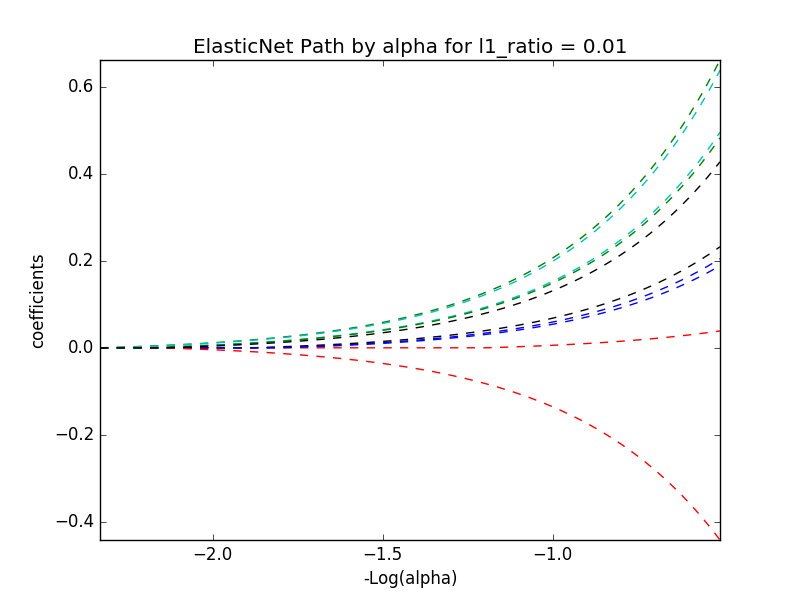

In [18]:
display(image)

### Run 2

In [20]:
# Start with alpha and l1_ratio values of 0.01, 0.75
train_diabetes(data, 0.01, 0.75)

Elasticnet model (alpha=0.010000, l1_ratio=0.750000):
 RMSE: 58.855838519
 MAE: 49.1630938927
 R2: 0.426255238123
Computing regularization path using the elastic net.

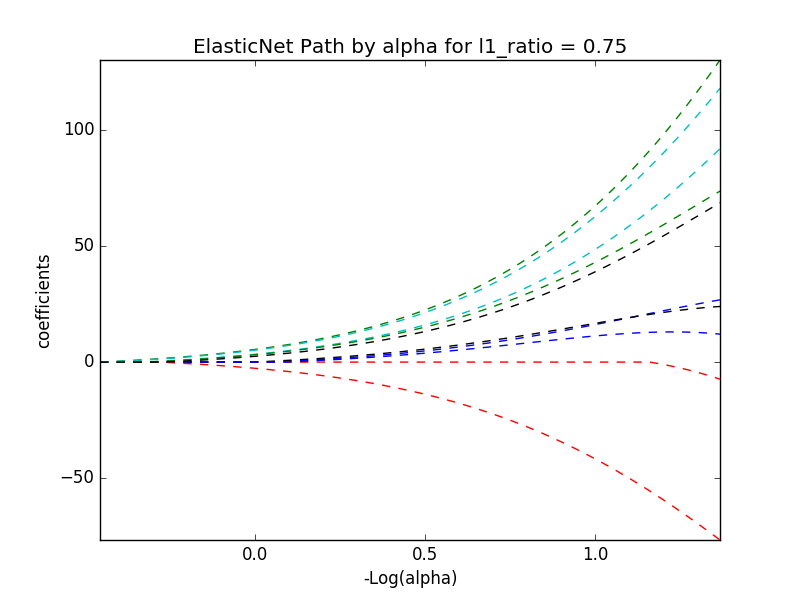

In [21]:
display(image)

### Run 3

In [23]:
# Start with alpha and l1_ratio values of 0.01, 1
train_diabetes(data, 0.01, 1)

Elasticnet model (alpha=0.010000, l1_ratio=1.000000):
 RMSE: 53.7811909082
 MAE: 43.4015882218
 R2: 0.520928362252
Computing regularization path using the elastic net.

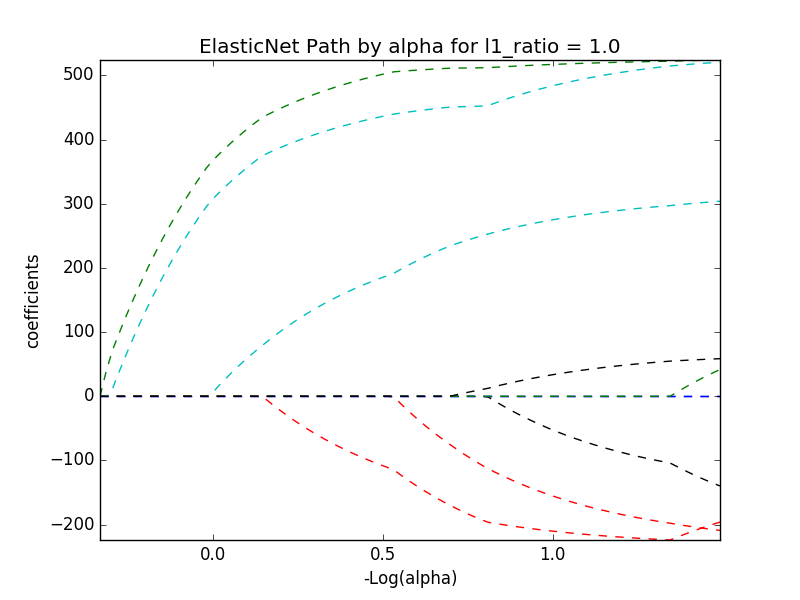

In [24]:
display(image)

## Visualiser des runs MLFlow

> Cliquer sur le bouton **Runs** en haut à droite

The experiment should look something similar to the animated GIF below. Inside the experiment, you can:
* View runs
* Review the parameters and metrics on each run
* Click each run for a detailed view to see the the model, images, and other artifacts produced.

<img src="https://docs.databricks.com/_static/images/mlflow/mlflow-ui.gif"/>

> Fin